In [14]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

FOLDERNAME = 'ENPM703/project/Final'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

Mounted at /content/drive


In [15]:
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from torchvision import transforms
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import precision_score, recall_score, roc_curve, auc
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [16]:
class AutismDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        self.filepaths = filepaths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = Image.open(self.filepaths[idx])
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [17]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)
        self.fc1 = nn.Linear(32 * 25 * 25, 300)
        self.fc2 = nn.Linear(300, 150)
        self.fc3 = nn.Linear(150, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))
        return x

In [18]:
# base_path = "/content/drive/MyDrive/ENPM703/Project/Final/Dataset/"
# classes = ["TC", "TS"]

# filepaths = []
# labels = []

# for class_dir in classes:
#     class_path = os.path.join(base_path, class_dir+'/Raw')
#     for filename in os.listdir(class_path):
#         if filename.endswith(('.png', '.jpg', '.jpeg')):
#             filepaths.append(os.path.join(class_path, filename))
#             labels.append(0 if class_dir == 'TC' else 1)

# train_filepaths, test_filepaths, train_labels, test_labels = train_test_split(
#     filepaths, labels, test_size=0.25, stratify=labels, random_state=42
# )

# transform = transforms.Compose([
#     transforms.Resize((100, 100)),
#     transforms.ToTensor(),
# ])

# train_dataset = AutismDataset(train_filepaths, train_labels, transform=transform)
# test_dataset = AutismDataset(test_filepaths, test_labels, transform=transform)

# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# all_labels = []
# all_predictions = []

In [19]:
base_path = "/content/drive/MyDrive/ENPM703/Project/Final/Dataset4/"
classes = ["TC", "TS"]

filepaths = []
labels = []

for class_dir in classes:
    class_path = os.path.join(base_path, class_dir)
    for filename in os.listdir(class_path):
        if filename.endswith(('.png', '.jpg', '.jpeg')):
            filepaths.append(os.path.join(class_path, filename))
            labels.append(0 if class_dir == 'TC' else 1)

train_filepaths, test_filepaths, train_labels, test_labels = train_test_split(
    filepaths, labels, test_size=0.25, stratify=labels, random_state=42
)

transform = transforms.Compose([
    transforms.Resize((100, 100)),
    transforms.ToTensor(),
])

train_dataset = AutismDataset(train_filepaths, train_labels, transform=transform)
test_dataset = AutismDataset(test_filepaths, test_labels, transform=transform)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

all_labels = []
all_predictions = []

Fold 1
Epoch 1/30, Train Loss: 0.6822, Train Accuracy: 0.5989, Val Loss: 0.6545, Val Accuracy: 0.7317
Epoch 2/30, Train Loss: 0.6298, Train Accuracy: 0.6369, Val Loss: 0.5936, Val Accuracy: 0.7317
Epoch 3/30, Train Loss: 0.5573, Train Accuracy: 0.7398, Val Loss: 0.5356, Val Accuracy: 0.7317
Epoch 4/30, Train Loss: 0.5580, Train Accuracy: 0.7615, Val Loss: 0.5081, Val Accuracy: 0.7805
Epoch 5/30, Train Loss: 0.5755, Train Accuracy: 0.7398, Val Loss: 0.5212, Val Accuracy: 0.7073
Epoch 6/30, Train Loss: 0.4824, Train Accuracy: 0.7859, Val Loss: 0.5141, Val Accuracy: 0.7073
Epoch 7/30, Train Loss: 0.4682, Train Accuracy: 0.7669, Val Loss: 0.5319, Val Accuracy: 0.7073
Epoch 8/30, Train Loss: 0.4667, Train Accuracy: 0.7859, Val Loss: 0.5448, Val Accuracy: 0.7073
Epoch 9/30, Train Loss: 0.4618, Train Accuracy: 0.7669, Val Loss: 0.5488, Val Accuracy: 0.6585
Epoch 10/30, Train Loss: 0.4456, Train Accuracy: 0.7995, Val Loss: 0.5452, Val Accuracy: 0.6585
Epoch 11/30, Train Loss: 0.4251, Train Acc

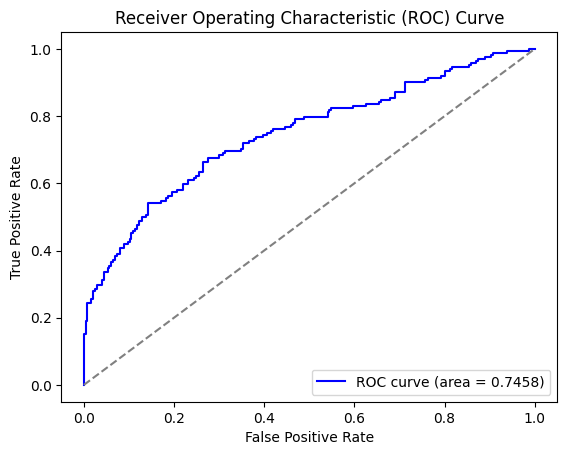

In [20]:
for fold, (train_idx, val_idx) in enumerate(skf.split(train_filepaths, train_labels)):
    print(f"Fold {fold + 1}")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=16, shuffle=False)

    model = CNNModel().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-3)

    num_epochs = 30
    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += ((outputs > 0.5) == labels).sum().item()

        train_accuracy = train_correct / len(train_subset)

        model.eval()
        val_loss, val_correct = 0, 0
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            val_correct += ((outputs > 0.5) == labels).sum().item()

        val_accuracy = val_correct / len(val_subset)

        print(f"Epoch {epoch + 1}/{num_epochs}, "
              f"Train Loss: {train_loss / len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}, "
              f"Val Loss: {val_loss / len(val_loader):.4f}, Val Accuracy: {val_accuracy:.4f}")

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions).flatten()

precision = precision_score(all_labels, (all_predictions > 0.5))
recall = recall_score(all_labels, (all_predictions > 0.5))

fpr, tpr, thresholds = roc_curve(all_labels, all_predictions)
roc_auc = auc(fpr, tpr)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

Test Accuracy: 0.5151
Test Precision: 0.6034
Test Recall: 0.6364
Test ROC AUC: 0.7681


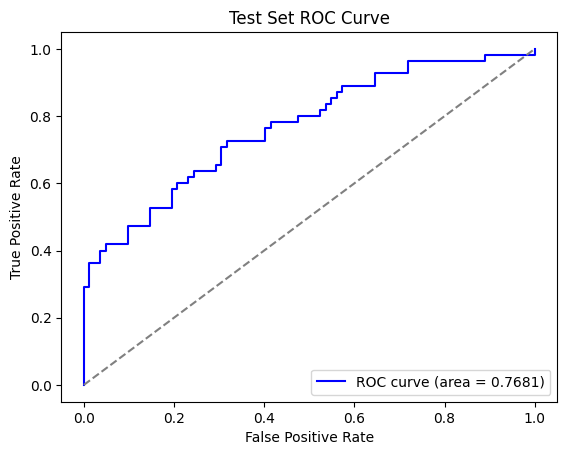

In [21]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model.eval()
test_labels = []
test_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        test_labels.extend(labels.cpu().numpy())
        test_predictions.extend(outputs.cpu().numpy())

test_labels = np.array(test_labels)
test_predictions = np.array(test_predictions).flatten()

test_accuracy = np.mean((test_predictions > 0.5) == test_labels)
test_precision = precision_score(test_labels, (test_predictions > 0.5))
test_recall = recall_score(test_labels, (test_predictions > 0.5))
test_fpr, test_tpr, test_thresholds = roc_curve(test_labels, test_predictions)
test_roc_auc = auc(test_fpr, test_tpr)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test ROC AUC: {test_roc_auc:.4f}")

plt.figure()
plt.plot(test_fpr, test_tpr, color='blue', label=f'ROC curve (area = {test_roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC Curve')
plt.legend(loc='lower right')
plt.show()